In [1]:
import numpy as np
import scipy.stats as stats 
from matplotlib import pyplot as plt
from matplotlib import style
style.use("seaborn")

## Thompson Sampling from Random Data

In [2]:
class BernoulliArm:
    
    def __init__(self, p):
        """Initialize a single instance of a Bernoulli Bandit arm with reward probability p.
        """
        self.p = p
        self.n = 0
        self.alpha = 1 
        self.beta = 1
        
    def pull(self):
        """Pull the arm of this instance of the arm.
        """
        self.n += 1
        return np.random.random() <= self.p
    
    def update(self, reward):
        """Update the estimation of the reward distribution for this arm.
        """
        self.alpha += reward
        self.beta += 1 - reward
        
    def sample(self, t):
        """Sample from the reward distribution of this arm. 
        """
        return np.random.beta(self.alpha, self.beta)

In [3]:
class ThompsonSampling:
    
    def __init__(self, arms, seed = 42):
        """Create an instance of a Bandit Algorithm model for arms (currently just Bernoulli) 
        with given reward probabilities.
        """
        self.arms = arms
        self.arm_pulls = []
        self.rewards = []
        self.seed = seed
        
    def run_experiment(self, num_trials):
        """Run an experiment with a given num_trials to update the estimate of the reward 
        distribution for each arm in the environment. 
        """
        np.random.seed(self.seed)
        for t in range(num_trials):
            samples = [arm.sample(t) for arm in self.arms]
            best_indx = np.argmax(samples)
            best_arm = self.arms[best_indx]
            reward = best_arm.pull()
            best_arm.update(reward)
            self.arm_pulls.append(best_indx)
            self.rewards.append(reward)
            
    def plot_reward_estimates(self):
        """Plot the density estimates for the arms in this environment.
        """
        colors = ["r", "g", "b", "y"]
        x = np.linspace(0, 1, 1000)
        max_y = np.max([stats.beta.pdf(x, a = arm.alpha, b = arm.beta) for arm in self.arms])
        for i in range(len(self.arms)):
            arm = self.arms[i]
            y = stats.beta.pdf(x, a = arm.alpha, b = arm.beta)
            mean = arm.alpha / (arm.alpha + arm.beta)
            plt.plot(x, y, label = arm.p, c = colors[i])
            plt.axvline(x = mean, ymin = 0, ymax = y[int(mean*1000)]/max_y, c = colors[i], linestyle = '--')
            
        plt.xlim(0,1)
        plt.ylim(0, max_y)
        plt.xlabel("Probability of Reward")
        plt.title("Thompson Sampling Density Estimates for Bernoulli Bandit")
        plt.legend(loc = "upper left")
        
    def plot_arm_pulls(self):
        """Plot the cumulative number of arm pulls for the experiment. 
        """
        colors = ["r", "g", "b", "y"]
        for i in range(len(self.arms)):
            arm = self.arms[i]
            arm_pulled = [1 if j == i else 0 for j in self.arm_pulls]
            plt.plot(range(len(arm_pulled)), np.cumsum(arm_pulled), label = arm.p, c = colors[i])
        
        plt.xlabel("Time")
        plt.ylabel("Cumulative Sum of Arm Pulls")
        plt.title("Cumulative Sum of Arm Pulls Over Time")
        plt.legend(loc = "upper left")
        
    def plot_pseudo_regret(self):
        """Plot the pseudo-regret for the experiment. 
        """
        num_trials = len(self.arm_pulls)
        best_arm = max([arm.p for arm in self.arms])
        optimal_seq = np.arange(1, num_trials + 1) * best_arm
        actual_seq = np.cumsum([self.arms[arm_index].p * 1 for arm_index in self.arm_pulls])
        pseudo_regret = optimal_seq - actual_seq
        
        plt.plot(pseudo_regret)
        plt.xlabel("Time")
        plt.ylabel("Pseudo-Regret")
        plt.title("Pseudo-Regret Over Time")
        
    def plot_random_regret(self):
        """Plot the random regret for the experiment. 
        """
        num_trials = len(self.arm_pulls)
        best_arm = max([arm.p for arm in self.arms])
        optimal_seq = np.arange(1, num_trials + 1) * best_arm
        actual_seq = np.cumsum(self.rewards)
        regret = optimal_seq - actual_seq
        
        plt.plot(regret)
        plt.xlabel("Time")
        plt.ylabel("Random Regret")
        plt.title("Regret Over Time")

In [4]:
seed = 10
reward_probabilities = [0.3, 0.3, 0.9]
arms = [BernoulliArm(p) for p in reward_probabilities]
num_trials = 300

model = ThompsonSampling(arms, seed)
model.run_experiment(num_trials)

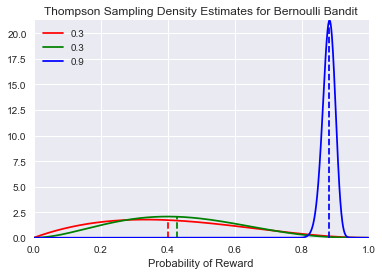

In [5]:
model.plot_reward_estimates()

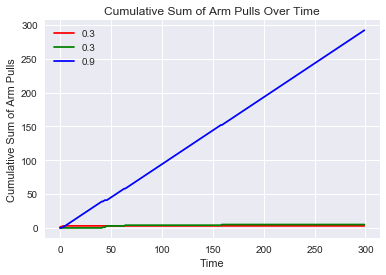

In [6]:
model.plot_arm_pulls()

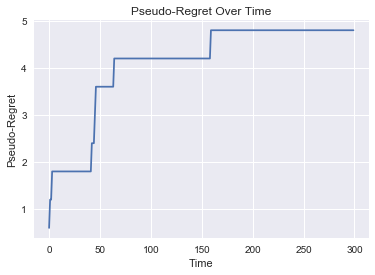

In [7]:
model.plot_pseudo_regret()

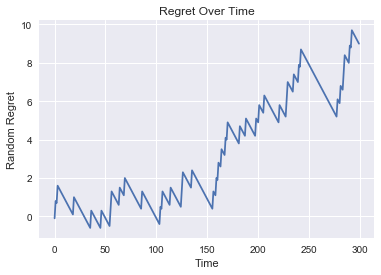

In [8]:
model.plot_random_regret()

## Thompson Sampling Model for Fixed Data

In [9]:
class FixedBernoulliArm(BernoulliArm):
    
    def __init__(self, p, reward_data):
        """Initialize a single instance of a Bernoulli Bandit arm with reward probability p where
        the reward distribution is fixed and generated from reward_data.
        """
        self.reward_data = reward_data
        self.i = 0
        super().__init__(p)
        
    def pull(self):
        """Simulate a pull of this instance of the arm of the bandit, where the reward is the ith value
        from the fixed sequence reward_data.
        """
        self.n += 1
        reward = self.reward_data[self.i]
        self.i += 1
        return reward

In [10]:
#how to reconcile what it wants to pull vs. what was actually pulled?


reward_stream_0 = [1,1,0,0,0,0,1,0,1,0]
reward_stream_1 = [0,0,0,0,0,0,0,0,0,0]
reward_stream_2 = [0,0,0,0,0,1,1,1,1,1]

seed = 10
num_trials = 10 
arm0 = FixedBernoulliArm(0.4, reward_stream_0)
arm1 = FixedBernoulliArm(0.0, reward_stream_1)
arm2 = FixedBernoulliArm(0.5, reward_stream_2)
arms = [arm0, arm1, arm2]

model = ThompsonSampling(arms, seed)
model.run_experiment(num_trials)

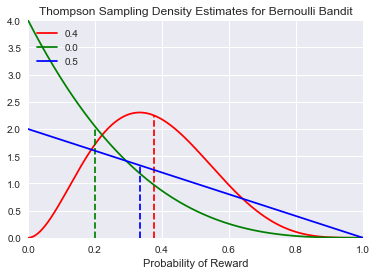

In [11]:
model.plot_reward_estimates()

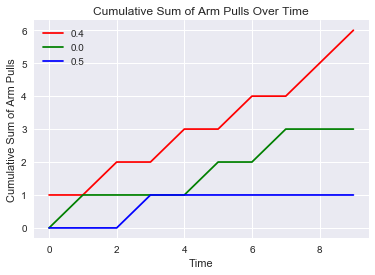

In [12]:
model.plot_arm_pulls()

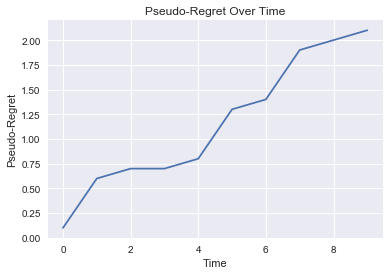

In [13]:
model.plot_pseudo_regret()

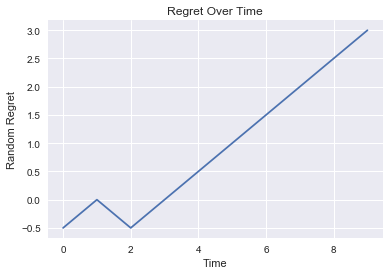

In [14]:
model.plot_random_regret()

## UCB on Random Data

In [237]:
class UCBBernoulliArm:
    
    def __init__(self, p, c = 1):
        self.p = p
        self.n = 0
        self.c = c
        self.mu_hat = 0
        
    def pull(self):
        """Pull the arm of this instance of the arm.
        """
        return np.random.random() <= self.p
    
    def update(self, reward):
        """Update the estimation of the reward distribution for this arm.
        """
        self.n += 1
        self.mu_hat = (((self.n - 1) * self.mu_hat) + reward) / self.n
        
    def sample(self, t):
        """Sample from the reward distribution of this arm. 
        """
        if self.n == 0:
            return np.float("inf")
        return self.mu_hat + self.c * np.sqrt(2 * np.log(t) / self.n)

In [238]:
class UCB:
    
    def __init__(self, arms, seed = 42):
        """Create an instance of a Bandit Algorithm model for arms (currently just Bernoulli) 
        with given reward probabilities.
        """
        self.arms = arms
        self.arm_pulls = []
        self.rewards = []
        self.seed = seed
        
    def run_experiment(self, num_trials):
        """Run an experiment with a given num_trials to update the estimate of the reward 
        distribution for each arm in the environment. 
        """
        np.random.seed(self.seed)
        for t in range(num_trials):
            samples = [arm.sample(t) for arm in self.arms]
            best_indx = np.argmax(samples)
            best_arm = self.arms[best_indx]
            reward = best_arm.pull()
            best_arm.update(reward)
            self.arm_pulls.append(best_indx)
            self.rewards.append(reward)
            
    def plot_reward_estimates(self, num_trials):
        """Plot the density estimates for the arms in this environment.
        """
        colors = ["r", "g", "b", "y"]
        mu_hats = []
        upper_bounds = []
        for i in range(len(self.arms)):
            arm = self.arms[i]
            mu_hat = arm.mu_hat
            upper_bound = arm.c * np.sqrt(2 * np.log(num_trials) / arm.n)
            mu_hats.append(mu_hat)
            upper_bounds.append(upper_bound)
                    
        plt.bar(range(len(self.arms)), mu_hats, yerr = [[0 for _ in range(len(self.arms))], upper_bounds], tick_label = [arm.p for arm in self.arms])
        plt.ylabel("Estimated Reward Probability")
        plt.xlabel("True Reward Probability for Arm")
        plt.xticks(range(len(self.arms)))
        plt.title("Reward Probability Estimates by Arm")
        
    def plot_arm_pulls(self):
        """Plot the cumulative number of arm pulls for the experiment. 
        """
        colors = ["r", "g", "b", "y"]
        for i in range(len(self.arms)):
            arm = self.arms[i]
            arm_pulled = [1 if j == i else 0 for j in self.arm_pulls]
            plt.plot(range(len(arm_pulled)), np.cumsum(arm_pulled), label = arm.p, c = colors[i])
        
        plt.xlabel("Time")
        plt.ylabel("Cumulative Sum of Arm Pulls")
        plt.title("Cumulative Sum of Arm Pulls Over Time")
        plt.legend(loc = "upper left")
        
    def plot_pseudo_regret(self):
        """Plot the pseudo-regret for the experiment. 
        """
        num_trials = len(self.arm_pulls)
        best_arm = max([arm.p for arm in self.arms])
        optimal_seq = np.arange(1, num_trials + 1) * best_arm
        actual_seq = np.cumsum([self.arms[arm_index].p * 1 for arm_index in self.arm_pulls])
        pseudo_regret = optimal_seq - actual_seq
        
        plt.plot(pseudo_regret)
        plt.xlabel("Time")
        plt.ylabel("Pseudo-Regret")
        plt.title("Pseudo-Regret Over Time")
        
    def plot_random_regret(self):
        """Plot the random regret for the experiment. 
        """
        num_trials = len(self.arm_pulls)
        best_arm = max([arm.p for arm in self.arms])
        optimal_seq = np.arange(1, num_trials + 1) * best_arm
        actual_seq = np.cumsum(self.rewards)
        regret = optimal_seq - actual_seq
        
        plt.plot(regret)
        plt.xlabel("Time")
        plt.ylabel("Random Regret")
        plt.title("Regret Over Time")

In [239]:
seed = 10
reward_probabilities = [0.3, 0.3, 0.9]
c = 1 #this is a fun little thing to play with
arms = [UCBBernoulliArm(p, c) for p in reward_probabilities]
num_trials = 300

model = UCB(arms, seed)
model.run_experiment(num_trials)

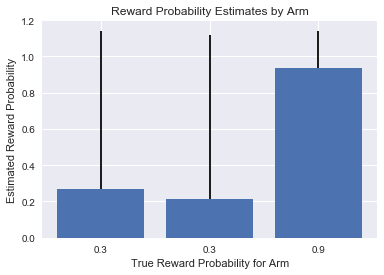

In [240]:
model.plot_reward_estimates(num_trials)

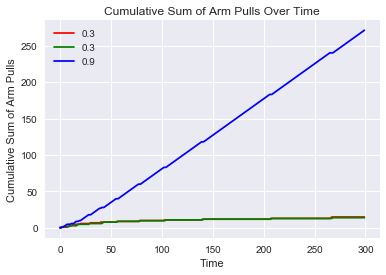

In [241]:
model.plot_arm_pulls()

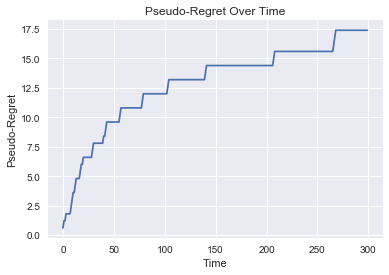

In [242]:
model.plot_pseudo_regret()

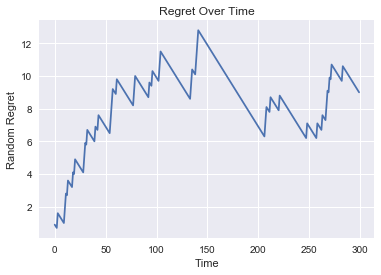

In [243]:
model.plot_random_regret()

## UCB on Fixed Data

In [244]:
class FixedUCBBernoulliArm(UCBBernoulliArm):
    
    def __init__(self, p, reward_data, c = 1):
        """Initialize a single instance of a Bernoulli Bandit arm with reward probability p where
        the reward distribution is fixed and generated from reward_data.
        """
        self.reward_data = reward_data
        self.i = 0
        super().__init__(p, c)
        
    def pull(self):
        """Simulate a pull of this instance of the arm of the bandit, where the reward is the ith value
        from the fixed sequence reward_data.
        """
        self.n += 1
        reward = self.reward_data[self.i]
        self.i += 1
        return reward

In [245]:
reward_stream_0 = [1,1,0,0,0,0,1,0,1,0]
reward_stream_1 = [0,0,0,0,0,0,0,0,0,0]
reward_stream_2 = [0,0,0,0,0,1,1,1,1,1]

seed = 10
num_trials = 10 
c = 1 #this is a fun little thing to play with
arm0 = FixedUCBBernoulliArm(0.4, reward_stream_0)
arm1 = FixedUCBBernoulliArm(0.0, reward_stream_1)
arm2 = FixedUCBBernoulliArm(0.5, reward_stream_2)
arms = [arm0, arm1, arm2]

model = UCB(arms, seed)
model.run_experiment(num_trials)

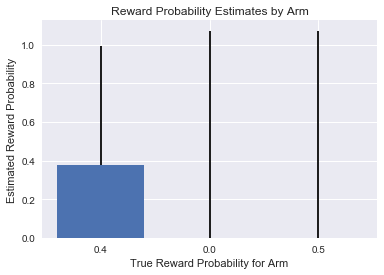

In [246]:
model.plot_reward_estimates(num_trials)

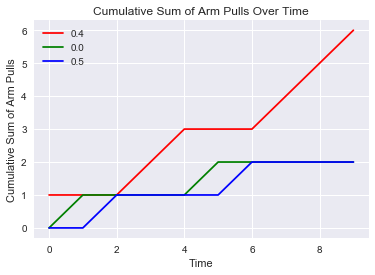

In [247]:
model.plot_arm_pulls()

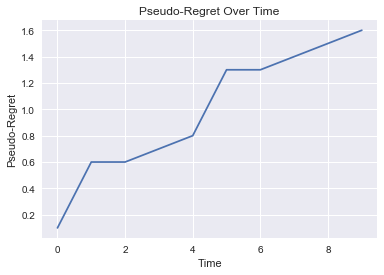

In [248]:
model.plot_pseudo_regret()

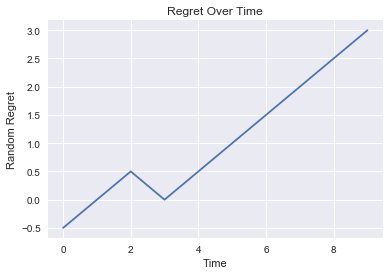

In [249]:
model.plot_random_regret()